### VGG16 합성곱 기반 층 만들기

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 6s 0us/step


#### VGG16 함수에 3개의 매개변수를 전달한다.
* ```weights```는 모델을 초기화할 가중치 체크포인트를 지정한다.
* ```include_top```은 네트워크의 최상위 완전 분류기를 포함할지 안 할지 지정한다. 기본값은 완전 연결 분류기를 포함하지만, 우리는 추가하려하므로 이를 포함시키지 않는다.
* ```input_shape```은 네트워크에 주입할 이미지 텐서의 크기이다. 이 값을 지정하지 않으면 어떤 크기의 입력도 처리할 수 있다.

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### 완전 연결층을 놓기위한 두 가지 방식
* 새로운 데이터셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장한다. 그 다음 데이터를 독립된 완전 연결 분류기에 입력으로 사용한다. 이 방식은 모든 입력이미지에 대해 합성곱 기반층을 한 번만 실행하면 되기 때문에 빠르고 비용이 적게 든다. 하지만 이런 이유로 인해 데이터 증식을 사용할 수없다.
* 준비한 모델(conv_model)위에 Dense을 쌓아 확장한다. 그다음 입력 데이터에서 엔드-투-엔드로 전체 모델을 실행한다. 모델에 노출된 입력 이미지가 매번 합성곱 기반 층을 통과하기 때문에 데이터 증식을 사용할 수 있지만, 비용이 많이든다.

### 데이터 증식을 사용하지 않은 첫번째 방식
> #### 사전 훈련된 합성곱 기반 층을 사용한 특성 추출

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'D:/jupyter_proj/케라스 창시자에게 배우는 딥러닝/합성곱 신경망/datasets/train/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode = 'binary')
    i=0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break # 모든 이미지를 한번씩 처리하고 나면 중지
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_label = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 완전 연결 분류기에 주입하기 전 (samples, 8192) 크기로 펼친다.

In [8]:
train_features = np.reshape(train_features, (2000, 4 * 4* 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4* 512))
test_features = np.reshape(test_features, (1000, 4 *4 * 512))

### 완전 연결 분류기를 정의하고 훈련하기

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

record = model.fit(train_features, train_labels,
                  epochs=30,
                  batch_size=20,
                  validation_data=(validation_features, validation_label))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6204 - acc: 0.6375 - val_loss: 0.4599 - val_acc: 0.8180
Epoch 2/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.4327 - acc: 0.8055 - val_loss: 0.3666 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3639 - acc: 0.8395 - val_loss: 0.3235 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3200 - acc: 0.8665 - val_loss: 0.3009 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2902 - acc: 0.8830 - val_loss: 0.2863 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2532 - acc: 0.9000 - val_loss: 0.2711 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2483 - acc: 0.9025 - val_loss: 0.2651 - val_acc: 0.8930
Epoch 8/30
200

### 결과 그래프 그리기

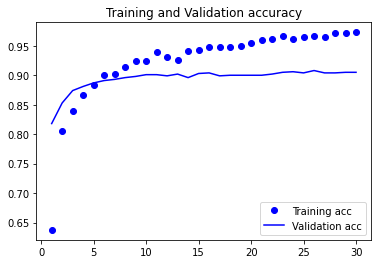

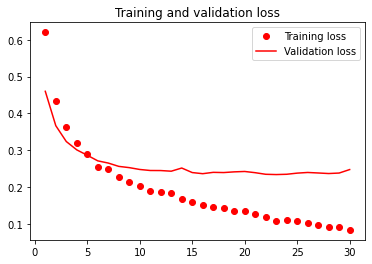

In [11]:
import matplotlib.pyplot as plt

acc = record.history['acc']
val_acc = record.history['val_acc']
loss = record.history['loss']
val_loss = record.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 데이터 증식을 하지 않았기 때문에 과대적합이 빨리 되는 것을 볼 수 있다.

### 데이터 증식을 사용한 특성 추출

* 이 기법은 연산 비용이 크기 때문에 GPU를 사용할 수 있을 때 시도해야 합니다. CPU에서는 적용하기 매우 힘듭니다. GPU를 사용할 수 없다면 첫번째 방법을 사용하세요..


### 미세 조정
> 특성 추출을 보완하기 위한 방법으로 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응 시키는 기법이다.